# Data Mining Lab 2
In this lab session we will focus on the use of Neural Word Embeddings

## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Other things you could try
6. Deep Learning
7. Word to Vector
8. Clustering
9. High-dimension Visualization



### Necessary Library Requirements:

#### Same as Lab1:
- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install via `pip3 install jupyter` and use `jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install via `pip3 sklearn` from a terminal
- [Pandas](http://pandas.pydata.org/)
    - Install via `pip3 install pandas` from a terminal
- [Numpy](http://www.numpy.org/)
    - Install via `pip3 install numpy` from a terminal
- [Matplotlib](https://matplotlib.org/)
    - Install via `pip3 maplotlib` from a terminal
- [Plotly](https://plot.ly/)
    - Install via `pip3 install plotly` from a terminal
- [Seaborn](https://seaborn.pydata.org/)
    - Install and signup for `seaborn`
- [NLTK](http://www.nltk.org/)
    - Install via `pip3 install nltk` from a terminal

#### New Libraries to install:
- [Gensim](https://pypi.org/project/gensim/)
    - Install via `pip3 install gensim`

- [tensorflow](https://www.tensorflow.org/)
    - Install via `pip3 install tensorflow`
    - Also install `pip3 install tensorflow-hub`

- [Keras](https://keras.io/)
    - Install via `pip3 install keras`

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embedding and other deep information retrieval approaches.

<!--![pic0](pics/pic0.png)-->
![pic0](https://drive.google.com/uc?export=view&id=1xrMKv0kRdx_QnKH-j4sw_bVNLntlhsr_)


---
## 1. Data Preparation

## 0. Load module

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 設定path
path = "/content/drive/MyDrive/Colab Notebooks/DM2023-Lab2-Master/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 下載 Google News 模型
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM" -O "GoogleNews-vectors-negative300.bin.gz" && rm -rf /tmp/cookies.txt
# !mv "/content/GoogleNews-vectors-negative300.bin.gz" "/content/drive/MyDrive/Colab Notebooks/DM2023-Lab2-Master/GoogleNews/GoogleNews-vectors-negative300.bin.gz"

In [ ]:
import pandas as pd

### training data
anger_train = pd.read_csv(path + "data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv(path + "data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv(path + "data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv(path + "data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [ ]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [ ]:
### testing data
anger_test = pd.read_csv(path +"data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv(path +"data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv(path +"data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv(path +"data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [ ]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [ ]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import plotly.graph_objs as go
# 首先我們利用CountVectorizer的參數max_features 來設定我們找出最頻繁出現的30個詞彙
coun_vect_train = CountVectorizer(max_features=30)
coun_vect_test = CountVectorizer(max_features=30)
# 帶入文章成立矩陣
count_matrix_train = coun_vect_train.fit_transform(train_df.text)
count_matrix_test = coun_vect_test.fit_transform(test_df.text)
print(count_matrix_train.shape)
print(count_matrix_test.shape)
# 列印取出的特徵
print(coun_vect_train.get_feature_names_out())
print(coun_vect_test.get_feature_names_out())
# 詞彙頻率矩陣
#使用np工具來達成計算，因原來是二維的矩陣，我們只求第一個為陣列
test_term_frequencies = np.asarray(count_matrix_test.sum(axis=0))[0]
test_term_frequencies[0]
display(test_term_frequencies)
train_term_frequencies = np.asarray(count_matrix_train.sum(axis=0))[0]
train_term_frequencies[0]
display(train_term_frequencies)

(3613, 30)
(347, 30)
['all' 'and' 'are' 'at' 'be' 'but' 'can' 'for' 'have' 'if' 'in' 'is' 'it'
 'just' 'like' 'me' 'my' 'not' 'of' 'on' 'so' 'that' 'the' 'this' 'to'
 'was' 'when' 'with' 'you' 'your']
['all' 'and' 'are' 'at' 'be' 'but' 'can' 'for' 'get' 'have' 'in' 'is' 'it'
 'just' 'like' 'me' 'my' 'not' 'of' 'on' 'so' 'that' 'the' 'this' 'to'
 'up' 'was' 'with' 'you' 'your']


array([ 30,  92,  29,  30,  40,  26,  32,  57,  26,  30,  69,  77,  83,
        29,  24,  36,  52,  24,  83,  46,  34,  55, 153,  24, 138,  24,
        34,  29,  82,  24])

array([ 243,  955,  231,  269,  383,  293,  257,  446,  312,  216,  626,
        787,  717,  301,  243,  380,  535,  303,  793,  390,  328,  537,
       1736,  350, 1289,  228,  226,  288,  796,  229])

In [ ]:
# 訓練集 Word frequency for Top 30 words in train dataset
# 首先將30個詞彙與相對出現次數結合成(30,2)的維度
x = np.asarray(coun_vect_train.get_feature_names_out()).reshape((30,1))
y = train_term_frequencies.reshape((30,1))
sum =  np.hstack((x, y))
# 將出現次數的詞彙由大到小排列
sum_sorted = np.array(sorted(sum, key=lambda row: row[1], reverse=True))
# 開始繪製長方圖
trace = go.Bar(x=sum_sorted[:,0],y=sum_sorted[:,1],name="詞彙出現次數")
layout = go.Layout(title="訓練集Top30詞彙量從大到小",xaxis={"title":"詞彙特徵"},
    yaxis={"title":"頻率"},barmode="group")

fig = go.Figure(data = [trace],layout=layout)
fig.show()

In [ ]:
# 訓練集 Word frequency for Top 30 words in test dataset
# 首先將30個詞彙與相對出現次數結合成(30,2)的維度
x = np.asarray(coun_vect_test.get_feature_names_out()).reshape((30,1))
y = test_term_frequencies.reshape((30,1))
sum =  np.hstack((x, y))
# 將出現次數的詞彙由大到小排列
sum_sorted = np.array(sorted(sum, key=lambda row: row[1], reverse=True))
# 開始繪製長方圖
trace = go.Bar(x=sum_sorted[:,0],y=sum_sorted[:,1],name="詞彙出現次數")
layout = go.Layout(title="測試集Top30詞彙量從大到小",xaxis={"title":"詞彙特徵"},
    yaxis={"title":"頻率"},barmode="group")

fig = go.Figure(data = [trace],layout=layout)
fig.show()

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [ ]:
## save to pickle file
train_df.to_pickle(path + "train_df.pkl")
test_df.to_pickle(path + "test_df.pkl")

In [ ]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle(path +"train_df.pkl")
test_df = pd.read_pickle(path +"test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [ ]:
# 標籤分類
train_df['emotion'].unique()

array(['fear', 'sadness', 'joy', 'anger'], dtype=object)

In [ ]:
# group to find distribution 每個標籤的數量
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

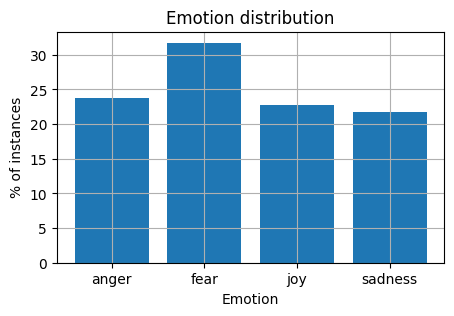

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()
# 各類別資料量並無太大差異

---

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer()

In [ ]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
# 丟進分析器學習每個單詞並編號(建立架構)
BOW_vectorizer.fit(train_df['text'])
# 2. Transform documents to document-term matrix.
# 將學習到的單詞向量化(將單字向量化)
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [ ]:
# check the result
train_data_BOW_features

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [ ]:
type(train_data_BOW_features)

scipy.sparse._csr.csr_matrix

In [ ]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [ ]:
test_data_BOW_features.shape

(347, 10115)

In [ ]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
feature_names[100:110]

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

In [ ]:
# Print the vocabulary learned
print("Vocabulary:", feature_names)
# Convert train data features to a dataframe to visualize
print("\nTrain data BOW features:")
print(pd.DataFrame(train_data_BOW_features.toarray(), columns=BOW_vectorizer.get_feature_names_out()))
# Convert test data features to a dataframe to visualize
print("\nTest data BOW features:")
print(pd.DataFrame(test_data_BOW_features.toarray(), columns=BOW_vectorizer.get_feature_names_out()))

Vocabulary: ['00' '000' '00pm' ... 'य_ब' 'सत' 'アニメ']

Train data BOW features:
      00  000  00pm  00tiffanyr  01  02  03  0303  034  04  ...  zoolander  \
0      0    0     0           0   0   0   0     0    0   0  ...          0   
1      0    0     0           0   0   0   0     0    0   0  ...          0   
2      0    0     0           0   0   0   0     0    0   0  ...          0   
3      0    0     0           0   0   0   0     0    0   0  ...          0   
4      0    0     0           0   0   0   0     0    0   0  ...          0   
...   ..  ...   ...         ...  ..  ..  ..   ...  ...  ..  ...        ...   
3608   0    0     0           0   0   0   0     0    0   0  ...          0   
3609   0    0     0           0   0   0   0     0    0   0  ...          0   
3610   0    0     0           0   0   0   0     0    0   0  ...          0   
3611   0    0     0           0   0   0   0     0    0   0  ...          0   
3612   0    0     0           0   0   0   0     0    0   0  ...

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [ ]:
"😂" in feature_names

False

Let's try using another tokenizer below.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize, token_pattern=None)
# apply analyzer to training data
BOW_500.fit(train_df['text'])
train_data_BOW_features_500 = BOW_500.transform(train_df['text'])
## check dimension
train_data_BOW_features_500.shape

(3613, 500)

In [ ]:
train_data_BOW_features_500.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['change', 'cheer', 'cheerful', 'cheerfully', 'cheering', 'cheery',
       'come', 'comes', 'could', 'country'], dtype=object)

In [ ]:
# Convert train data features to a dataframe to visualize
print("\nTrain data BOW features:")
print(pd.DataFrame(train_data_BOW_features_500.toarray(), columns=BOW_500.get_feature_names_out()))


Train data BOW features:
      !  #  $  %  &  '  'd  'll  'm  're  ...  year  years  yet  you  your  \
0     0  1  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
1     0  2  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
2     0  2  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
3     0  1  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
4     0  0  0  0  0  0   0    0   0    0  ...     1      0    0    1     0   
...  .. .. .. .. .. ..  ..  ...  ..  ...  ...   ...    ...  ...  ...   ...   
3608  0  0  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
3609  1  1  0  0  0  0   0    0   0    0  ...     0      0    0    0     2   
3610  0  1  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
3611  0  2  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   
3612  0  0  0  0  0  0   0    0   0    0  ...     0      0    0    0     0   

      yourself  ’  “  ”  😂  
0       

In [ ]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [ ]:
# Answer here
# 從每個文本的標記生成TF-IDF特徵(1000 features)。
# 這將產生一個文件矩陣，但是，權重將以不同的方式計算
# 使用每份文件中每個單詞的TF-IDF值，而非單詞頻率(BOW)。
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vectorizer_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize, token_pattern=None)
X_Tfidf_1000 = Tfidf_vectorizer_1000.fit_transform(train_df['text'])
# Convert train data features to a dataframe to visualize
print("\nTrain data TF-IDF features:")
print(pd.DataFrame(X_Tfidf_1000.toarray(), columns=Tfidf_vectorizer_1000.get_feature_names_out()))


Train data TF-IDF features:
             !         #    $    %    &    '   'd  'll   'm  're  ...    ’  \
0     0.000000  0.094607  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1     0.000000  0.321449  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2     0.000000  0.238199  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3     0.000000  0.168372  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4     0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3608  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3609  0.148523  0.091935  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3610  0.000000  0.135209  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3611  0.000000  0.174057  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3612  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

        “    ”   ❤️    😂   😂😂    😕

In [ ]:
# show the feature names for features [100:110].
feature_names_1000 = Tfidf_vectorizer_1000.get_feature_names_out()
feature_names_1000[100:110]

array(['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc',
       'bday'], dtype=object)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train_BOW_500 = BOW_500.transform(train_df['text'])
y_train_BOW_500 = train_df['emotion']
X_test_BOW_500 = BOW_500.transform(test_df['text'])
y_test_BOW_500 = test_df['emotion']
## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train_BOW_500.shape)
print('y_train.shape: ', y_train_BOW_500.shape)
print('X_test.shape: ', X_test_BOW_500.shape)
print('y_test.shape: ', y_test_BOW_500.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [ ]:
display(y_train_BOW_500)

1035       fear
2996    sadness
2100        joy
882        fear
2118        joy
         ...   
3287    sadness
1787       fear
3495    sadness
3211    sadness
846       anger
Name: emotion, Length: 3613, dtype: object

In [ ]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)
## training!
DT_model = DT_model.fit(X_train_BOW_500, y_train_BOW_500)
## predict!
y_train_pred_BOW_500 = DT_model.predict(X_train_BOW_500)
y_test_pred_BOW_500 = DT_model.predict(X_test_BOW_500)
## so we get the pred result
print("BOW_500:",y_test_pred_BOW_500[:10])

BOW_500: ['sadness' 'anger' 'joy' 'anger' 'anger' 'anger' 'fear' 'fear' 'joy'
 'fear']


---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [ ]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train_BOW_500, y_pred=y_train_pred_BOW_500)
acc_test = accuracy_score(y_true=y_test_BOW_500, y_pred=y_test_pred_BOW_500)
print('BOG_training accuracy: {}'.format(round(acc_train, 3)))
print('BOG_testing accuracy: {}'.format(round(acc_test, 3)))

BOG_training accuracy: 0.986
BOG_testing accuracy: 0.68


In [ ]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report
print("BOW500")
print(classification_report(y_true=y_test_BOW_500, y_pred=y_test_pred_BOW_500))

BOW500
              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



In [ ]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test_BOW_500, y_pred=y_test_pred_BOW_500)
print("BOW500")
print(cm)

BOW500
[[57 18  6  3]
 [16 76  9  9]
 [ 6  9 56  8]
 [ 7 13  7 47]]


In [ ]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

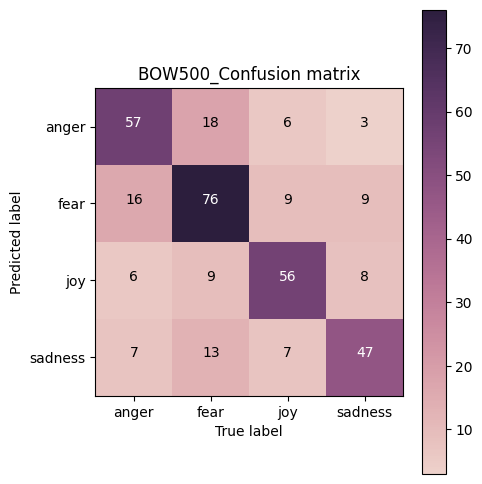

In [ ]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='BOW500_Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

#### Answer here
* 從混淆矩陣和classification_report中可以發現，無論是預測標籤為fear,但正確標籤為anger，甚至雙方顛倒過來，皆有大部分的誤判，可以發現說當模型在這兩個標籤的對立面上，誤判甚高。其次預測標籤為sadness,但正確標籤為fear的結果，還有預測標籤為fear,但正確標籤為joy的結果,這兩種組合的誤判率也是我們須注意的地方。


---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results?

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [ ]:
# Answer here
from sklearn.naive_bayes import BernoulliNB

## build model
NB_model = BernoulliNB(alpha = 1.0)
## training!
NB_model.fit(X_train_BOW_500, y_train_BOW_500)
## predict!
y_train_pred = NB_model.predict(X_train_BOW_500)
y_test_pred = NB_model.predict(X_test_BOW_500)
## so we get the pred result
print("Naive Bayes_Tfidf:",y_test_pred[:10])

Naive Bayes_Tfidf: ['anger' 'anger' 'joy' 'anger' 'anger' 'anger' 'fear' 'joy' 'sadness'
 'fear']


In [ ]:
## accuracy and testing results
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train_BOW_500, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test_BOW_500, y_pred=y_test_pred)
print('Naive Bayes_training accuracy: {}'.format(round(acc_train, 3)))
print('Naive Bayes_testing accuracy: {}'.format(round(acc_test, 3)))

Naive Bayes_training accuracy: 0.794
Naive Bayes_testing accuracy: 0.7


In [ ]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_BOW_500, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.61      0.68      0.64        84
        fear       0.74      0.76      0.75       110
         joy       0.81      0.68      0.74        79
     sadness       0.66      0.65      0.65        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.70       347
weighted avg       0.71      0.70      0.70       347



[[57 13  5  9]
 [15 84  3  8]
 [10  7 54  8]
 [11 10  5 48]]


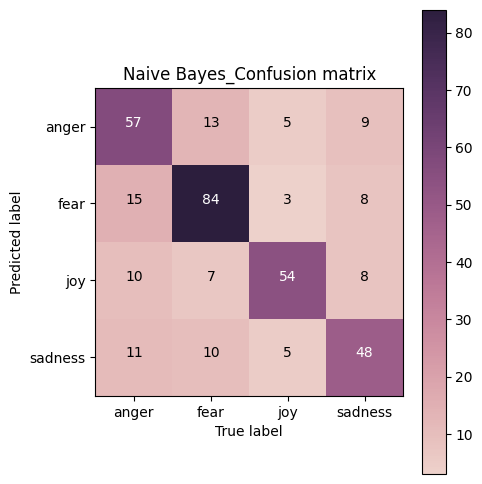

In [ ]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test_BOW_500, y_pred=y_test_pred)
print(cm)
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Naive Bayes_Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

#### Answer here
* 首先從 classification_report 中可以發現，Decision Tree的分類器對於訓練資料的精準度有明顯優勢。相對測試資料而言，Naive Bayes的分類器在於測試資料的精準度較高於訓練資料。從兩種分類器從我們可以發現，Naive Bayes 基於貝氏定理，假定特徵之間是獨立的，對於高度相關的特徵可能表現不佳。因此在訓練時對於大規模和高維數據通常表現得很好。而Decision Tree用樹狀結構來進行分類，通過根據特徵的不同值來分割數據。每個分割點都是基於某個條件，使得在樹的每個節點上都有一個決策。因此在處理非獨立特徵時，可以在樹的不同分支上會多次使用相同的特徵。
* 在本次實驗，因為我們有限制只抓取前500個頻率相對較大的特徵，除了在維度部分有限制外，訓練資料不夠多的情形下，其在訓練的精準度上，Naive Bayes分數會低於決策樹的原因；相對決策樹因為善於處理非獨立特徵，可在樹的不同分支上使用相同特徵多次。但相對地決策樹遇到噪音非常敏感，在沒有數據清理的情況，雖然訓練資料的精準度上非常好，但在預測未知的測試資料，表現不甚理想，而Naive Bayes對於每個特徵之間是獨立的，在面對噪音或異常值得情境上相對優勢。
* 因此在選擇使用哪一種模型通常取決於數據的特點以及問題的性質。


---

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by:
- Trying different features (Feature engineering)e.g Word2Vec, PCA, LDA, FastText, Clustering
- Trying different models
- Analyzing your results and interpret them to improve your feature engineering/model building process
- Iterate through the steps above until finding a satisfying result

Remember that you should also consider the task at hand and the model you'll feed the data to.

### Bonus: Compare fit -> transform and fit -> predict

In [ ]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(test_df['text'])

# 2. Transform documents to document-term matrix
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])


In [ ]:
# Training set and Testing set
X_train = train_data_BOW_features
y_train = train_df['emotion']

X_test = test_data_BOW_features
y_test = test_df['emotion']

## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

### Bonus: Randon Forest

training accuracy: 0.98
testing accuracy: 0.82
              precision    recall  f1-score   support

       anger       0.78      0.81      0.80        84
        fear       0.81      0.87      0.84       110
         joy       0.90      0.84      0.87        79
     sadness       0.82      0.76      0.79        74

    accuracy                           0.82       347
   macro avg       0.83      0.82      0.82       347
weighted avg       0.83      0.82      0.82       347



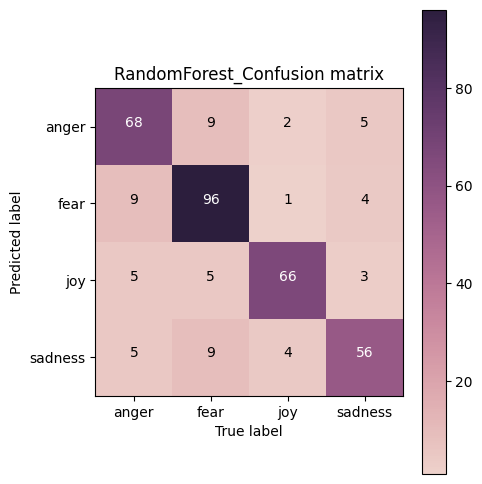

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## build RandomForest model
RF_model = RandomForestClassifier(n_estimators=100, random_state=1) #100 trees in the forest

## training!
RF_model.fit(X_train, y_train)

## predict!
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

print(classification_report(y_true=y_test, y_pred=y_test_pred))

## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='RandomForest_Confusion matrix')


#### Randon Forest output the pdf of graph

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus

### for instance, to visualize the first three trees from forest:
for idx, tree in enumerate(RF_model.estimators_[:3]):
    dot_data = export_graphviz(tree, out_file=None)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf(f"random-forest-tree{idx}.pdf")

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models.

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

<!-- ![Fully Connected Network](pics/pic1.png) -->
![Fully Connected Network](https://drive.google.com/uc?id=1xiET6RSGzgvV4ipD6k7oZy3HtvQpvno4)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [ ]:
import keras

# standardize name (X, y)
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves.

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [ ]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1035       fear
2996    sadness
2100        joy
882        fear
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [ ]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


<!-- ![Imgur](pics/pic2.png) -->
![Imgur](https://drive.google.com/uc?id=1xh_tPrNq9v-7xys0qcBzFEmOZejD4i4a)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)
# train_500 -> 64 -> 64 -> [4] -> [0.6,0.3,0.1,0]
model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

### 6.4 Train

In [ ]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(path + 'logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32 # 總共3613筆資料, 並非全部丟進去訓練，而是分32筆進行批次處理，等於每回合要處理113筆資料才會更新一次參數

# training!
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25
113/113 [==============================] - 3s 11ms/step - loss: 1.3144 - accuracy: 0.3930 - val_loss: 1.2479 - val_accuracy: 0.4813
Epoch 2/25
113/113 [==============================] - 1s 7ms/step - loss: 0.9376 - accuracy: 0.6687 - val_loss: 0.9112 - val_accuracy: 0.6772
Epoch 3/25
113/113 [==============================] - 1s 6ms/step - loss: 0.5662 - accuracy: 0.7982 - val_loss: 0.8167 - val_accuracy: 0.6772
Epoch 4/25
113/113 [==============================] - 1s 6ms/step - loss: 0.4077 - accuracy: 0.8539 - val_loss: 0.7698 - val_accuracy: 0.6945
Epoch 5/25
113/113 [==============================] - 1s 11ms/step - loss: 0.3241 - accuracy: 0.8846 - val_loss: 0.8376 - val_accuracy: 0.7032
Epoch 6/25
113/113 [==============================] - 1s 5ms/step - loss: 0.2675 - accuracy: 0.9081 - val_loss: 0.8699 - val_accuracy: 0.6916
Epoch 7/25
113/113 [==============================] - 0s 4ms/step - loss: 0.2186 - accuracy: 0.9286 - val_loss: 0.9225 - val_accuracy: 0.6744
Epoc

### 6.5 Predict on testing data

In [ ]:
## predict
pred_result = model.predict(X_test, batch_size=128) # 共347筆, 共處理三回合
pred_result[:5]

3/3 [==============================] - 0s 7ms/step


array([[7.3887646e-02, 3.5037762e-03, 8.2402027e-01, 9.8588340e-02],
       [6.5314794e-01, 2.1745643e-02, 6.0025770e-03, 3.1910390e-01],
       [3.4347807e-12, 3.7705642e-15, 9.9999994e-01, 9.0402113e-12],
       [2.1308763e-01, 7.8600037e-01, 5.2381307e-04, 3.8826861e-04],
       [9.9999982e-01, 2.2766127e-08, 1.7950484e-10, 1.3475928e-07]],
      dtype=float32)

In [ ]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['joy', 'anger', 'joy', 'fear', 'anger'], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.67


In [ ]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv(path + "logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.393025,1.314379,0.481268,1.247938
1,1,0.668696,0.937627,0.677233,0.911182
2,2,0.798229,0.566162,0.677233,0.816698
3,3,0.853861,0.407726,0.694524,0.769849
4,4,0.884583,0.324104,0.703170,0.837650
5,5,0.908110,0.267470,0.691643,0.869921
6,6,0.928591,0.218591,0.674352,0.922479
7,7,0.942707,0.179604,0.688761,0.981173
8,8,0.954608,0.157229,0.688761,1.055260
9,9,0.962081,0.135554,0.665706,1.086320


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="https://drive.google.com/uc?id=1yyKQlYTdVmBTJw_9hYHzF1r6eFmmJEb2" style="width: 300px;"/> </td>
    <td><img src="https://drive.google.com/uc?id=1yqTIlNjs1VtIpKwWaDbV37g70FqggwnY" style="width: 300px;"/> </td>
</tr></table>

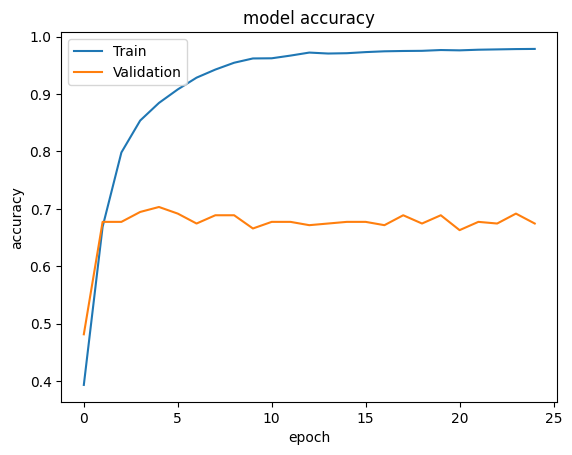

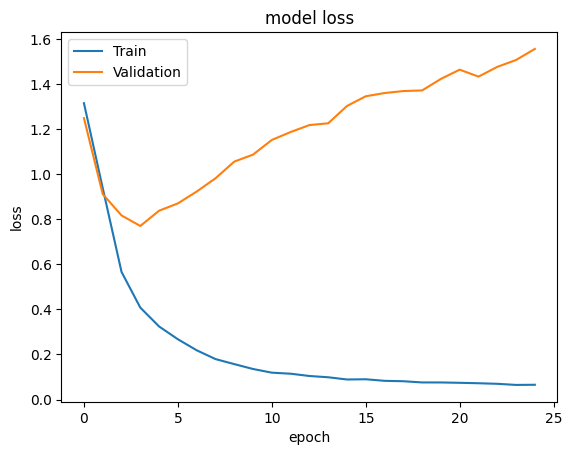

In [ ]:
# Answer here
import matplotlib.pyplot as plt
training_log
# summarize history for accuracy
plt.plot(training_log['accuracy'])
plt.plot(training_log['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_log['loss'])
plt.plot(training_log['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


* 我們從上圖模型的Loss學習曲線來解釋為何最終訓練發生的是 overfitting 。一個適合的模型的學習曲線在開始時雖會有較高的訓練或驗證的Loss，但隨著增加訓練範例逐漸降低並逐漸平坦，表明增加更多的訓練範例並不會改善模型在訓練數據上的性能，甚至不會改善模型對未見數據的性能。
* 但從圖表中，training loss 一直在不斷地下降，而validation loss 在訓練不到5回合的請況不再下降反而開始上升，代表 model 已經過度迎合 training data 或甚至把噪音和隨機波動也學進來了。
* 因此要降低overfitting有幾種方法
    1. 增加 regularization
    2. 收集更多 data
    3. 精簡 features
    4. 減低 model complexity

---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [ ]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
1035,20178,my husband lost £800 when he booked an apartme...,"[my, husband, lost, £800, when, he, booked, an..."
2996,40169,"@midnight #EndTrumpweek please, it's #depressi...","[@, midnight, #, EndTrumpweek, please, ,, it, ..."
2100,30096,Probably the best OT period I've ever seen. Ab...,"[Probably, the, best, OT, period, I, 've, ever..."
882,20025,Super shitting it about this tattoo #nervous,"[Super, shitting, it, about, this, tattoo, #, ..."
2118,30114,Happy birthday @iRidhiDogra keep smiling alway...,"[Happy, birthday, @, iRidhiDogra, keep, smilin..."


In [ ]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['my', 'husband', 'lost', '£800', 'when', 'he', 'booked', 'an', 'apartment', 'through', '@', 'Airbnb', 'that', 'did', "n't", 'exist', '...', '@', 'AirbnbHelp', 'did', "n't", 'care', '#', 'airbnbnightmare']),
       list(['@', 'midnight', '#', 'EndTrumpweek', 'please', ',', 'it', "'s", '#', 'depressing', 'me', '.']),
       list(['Probably', 'the', 'best', 'OT', 'period', 'I', "'ve", 'ever', 'seen', '.', 'Absolutely', 'exhilarating', '.', '#', 'WCH2016', '#', 'TeamNA'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5 # sliding window
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus,
                          vector_size=vector_dim, window=window_size,
                          min_count=min_count, epochs=training_epochs)

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [ ]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy'] # 將文字轉向量
display(word_vec.shape)
word_vec

(100,)

array([ 0.8301158 ,  0.2823213 ,  0.03652112,  0.02608245, -0.507081  ,
       -0.6611512 ,  0.535876  ,  1.0588545 , -0.22580627, -0.53447497,
       -0.51669246, -0.54670775, -0.6095446 , -0.10455693, -0.32190078,
       -0.5009341 ,  0.24760371, -0.52585435, -0.06535593, -1.1080776 ,
        0.2641673 ,  0.6550729 ,  0.23840335,  0.665697  ,  0.6010206 ,
       -0.0897055 , -0.8720564 ,  0.45809034, -0.36355892,  0.1996566 ,
       -0.10362936, -0.43432483,  0.45384288, -0.85105544, -0.05740035,
        0.58114177,  0.3533522 , -0.32990596, -0.6820683 , -0.39070272,
       -0.08925425, -0.417325  , -0.2539882 ,  0.35326943,  0.7486834 ,
       -0.47302672, -0.48438105,  0.4302881 ,  0.6957484 ,  0.71682835,
       -0.32571027, -0.6332314 ,  0.2241554 ,  0.1539441 , -0.36061135,
       -0.22569351,  0.27808332, -0.34071037, -0.26970062,  0.13699566,
       -0.2278224 , -0.35534838,  1.0797852 ,  0.02460948, -0.88095087,
        0.8392047 ,  0.15507233,  0.72403204, -1.2497745 ,  0.64

In [ ]:
# 確定這個向量是否能代表該字且與該字相似的單字
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('birthday', 0.9325679540634155),
 ('right', 0.9146103262901306),
 ('Makes', 0.9142266511917114),
 ('Be', 0.9141619801521301),
 ('bday', 0.9131302237510681),
 ('smile', 0.9072205424308777),
 ('free', 0.9036478400230408),
 ('dad', 0.9032801985740662),
 ('establishment', 0.900655210018158),
 ("'you", 0.8956668972969055)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [ ]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = path + "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
#解壓縮取的模型
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [ ]:
import gensim.downloader as api

# 使用其他模型 :glove-twitter-25
## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

[==================================================] 100.0% 104.8/104.8MB downloaded
load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [ ]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence).
How can we utilize these "word" vectors to represent the sentence data and train our model?
* [Migrating from Gensim 3.x to 4](https://github.com/piskvorky/gensim/wiki/Migrating-from-Gensim-3.x-to-4)
* [Doc2VEC]( https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html)
* [reference](https://spotintelligence.com/2023/09/06/doc2vec/)


In [ ]:
# Answer here
# 我們如何利用這些"單詞"向量(word embedding)來表示成句子(sentence embedding)並訓練我們的模型呢？
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# the input type 、training data 、testing data
## the training data
print("training data")
display(training_corpus[:2])
## the testing data
test_df['text_tokenized'] = test_df['text'].apply(lambda x: nltk.word_tokenize(x))
## create the training corpus
testing_corpus = test_df['text_tokenized'].values
print("testing data")
display(testing_corpus[:2])
# Doc2Vec need a corpus of text documents, Ensure your data is preprocessed and tokenized
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(training_corpus)]
print("tagged_data: ")
display(tagged_data[:2])

# Initialize the Doc2Vec model
model = Doc2Vec(vector_size=100,  # Dimensionality of the document vectors
                window=5,         # Maximum distance between the current and predicted word within a sentence
                min_count=1,      # Ignores all words with total frequency lower than this
                # workers=4,        # Number of CPU cores to use for training
                epochs=20)        #20 Number of training epochs

# Build the vocabulary
model.build_vocab(tagged_data)
# Train the model
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# 可以查詢單字的頻率
print(f"Word 'good' appeared {model.wv.get_vecattr('good', 'count')} times in the training corpus.")

training data


array([list(['A', 'pessimist', 'is', 'someone', 'who', ',', 'when', 'opportunity', 'knocks', ',', 'complains', 'about', 'the', 'noise', '.']),
       list(['@', 'gypsydragoness', 'wrinkling', 'up', '.', "'Well", 'now', ',', 'looks', 'here', 'like', 'your', 'name', 'starts', 'with', 'the', 'letter', 'G', ',', 'eh', '?', "'", 'The', 'man', 'smiled', 'up', 'and', 'gave', 'a', 'hearty', '+'])],
      dtype=object)

testing data


array([list(['@', 'PhilGlutting', 'Hey', 'There', 'Phil', 'Glutting', 'thank', 'you', 'for', 'following', 'us', ',', 'it', "'s", 'appreciated', ':', ')']),
       list(['Honestly', ',', 'there', 'are', 'some', 'awful', 'people', 'on', 'the', 'internet', '...', 'smh', '...'])],
      dtype=object)

tagged_data: 


[TaggedDocument(words=['A', 'pessimist', 'is', 'someone', 'who', ',', 'when', 'opportunity', 'knocks', ',', 'complains', 'about', 'the', 'noise', '.'], tags=[0]),
 TaggedDocument(words=['@', 'gypsydragoness', 'wrinkling', 'up', '.', "'Well", 'now', ',', 'looks', 'here', 'like', 'your', 'name', 'starts', 'with', 'the', 'letter', 'G', ',', 'eh', '?', "'", 'The', 'man', 'smiled', 'up', 'and', 'gave', 'a', 'hearty', '+'], tags=[1])]

Word 'good' appeared 94 times in the training corpus.


array([ 0.02900367, -0.06929082,  0.03426417,  0.03974256, -0.10269355,
       -0.05091811,  0.08548813,  0.12816632, -0.12582937, -0.04303921,
       -0.02924232, -0.11887633,  0.07306192,  0.03784265, -0.04724677,
        0.04394122,  0.12052067,  0.00420385, -0.1279187 , -0.11751787,
        0.04499884,  0.09741767,  0.15098245, -0.00350643,  0.02147149,
        0.04735266, -0.0132035 ,  0.05167937, -0.15209666, -0.00694911,
        0.02906505,  0.01339937, -0.00896881, -0.01942361, -0.04385189,
        0.05745322,  0.04798193, -0.00971036,  0.0242628 , -0.01122675,
        0.07535642, -0.03272515, -0.02346154,  0.0172035 ,  0.17155522,
        0.0174665 , -0.0372007 , -0.10247184,  0.04977955,  0.07848358],
      dtype=float32)

------


array([ 0.00225146, -0.05009291,  0.00574506,  0.03420398, -0.06203282,
       -0.0346412 ,  0.01796225,  0.0607181 , -0.09523115, -0.02715253,
       -0.00989666, -0.06183672,  0.03169981,  0.0197524 , -0.03474728,
        0.0102086 ,  0.08503212,  0.01074989, -0.09545337, -0.07928248,
        0.02430831,  0.07025307,  0.08545905,  0.00676708,  0.02319329,
        0.01401594, -0.02337527,  0.01052178, -0.07551453, -0.02079715,
        0.02430214,  0.01203848, -0.01495612, -0.0259263 , -0.03006816,
        0.03315084,  0.03393672, -0.02372828,  0.01168722,  0.00705056,
        0.04372459, -0.03701983, -0.01374265,  0.00013566,  0.10180074,
       -0.00806865, -0.02139845, -0.06158819,  0.04213873,  0.03573065],
      dtype=float32)

cosine similarity:  0.96223533
training accuracy: 1.0
testing accuracy: 0.28
              precision    recall  f1-score   support

       anger       0.16      0.11      0.13        84
        fear       0.33      0.58      0.42       110
         joy       0.25      0.19      0.22        79
     sadness       0.24      0.12      0.16        74

    accuracy                           0.28       347
   macro avg       0.25      0.25      0.23       347
weighted avg       0.25      0.28      0.25       347



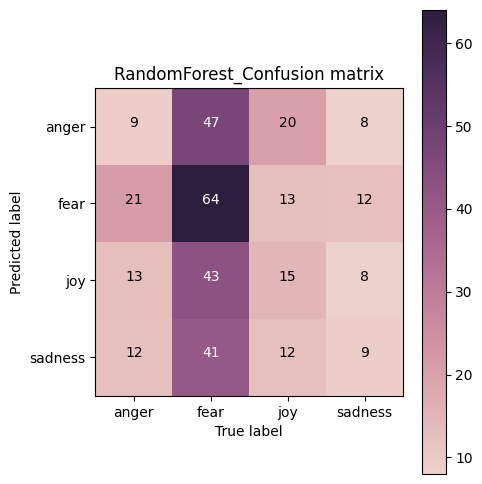

In [ ]:
# Infer a vector for a new document
inferred_vector = model.infer_vector(['A', 'pessimist', 'is', 'someone', 'who', ',', 'when', 'opportunity', 'knocks', ',', 'complains', 'about', 'the', 'noise', '.'])
display(inferred_vector)
print("------")
# Get the vector for an existing document by tag
existing_document_vector = model.dv[0]
display(existing_document_vector)
# 接下來可以使用推斷的文件向量進行各種任NLP務，例如similarity, classification, or retrieval.
# Define a function which returns the cosine similarity between 2 vectors
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
print("cosine similarity: ",cosine(inferred_vector, existing_document_vector))

# extract Doc2Vec embeddings
doc_vectors = [model.dv[idx] for idx in range(len(tagged_data))]

# build RandomForest model
RF_model = RandomForestClassifier(n_estimators=50, random_state=42) #100 trees in the forest

# Split the data into training and testing sets
X_train = doc_vectors
y_train = train_df['emotion']
X_test = [model.infer_vector(x) for x in testing_corpus]
y_test = test_df['emotion']

## training!
RF_model.fit(X_train, y_train)

## predict!
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

print(classification_report(y_true=y_test, y_pred=y_test_pred))

## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='RandomForest_Confusion matrix')



### 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [ ]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]
print(X[0])

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
[ 0.8301158   0.2823213   0.03652112  0.02608245 -0.507081   -0.6611512
  0.535876    1.0588545  -0.22580627 -0.53447497 -0.51669246 -0.54670775
 -0.6095446  -0.10455693 -0.32190078 -0.5009341   0.24760371 -0.52585435
 -0.06535593 -1.1080776   0.2641673   0.6550729   0.23840335  0.665697
  0.6010206  -0.0897055  -0.8720564   0.45809034 -0.36355892  0.1996566
 -0.10362936 -0.43432483  0.45384288 -0.85105544 -0.05740035  0.58114177
  0.3533522  -0.32990596 -0.6820683  -0.39070272 -0.08925425 -0.417325
 -0.2539882   0.35326943  0.7486834  -0.47302672 -0.48438105  0.4302881
  0.6957484   0.71682835 -0.32571027 -0.6332314   0.2241554   0.1539441
 -0.36061135 -0.22569351  0.27808332 -0.34071037 -0.26970062  0.13699566
 -0.2278224  -0.35534838  1.0797852   0.02460948 -0.88095087  0.8392047
  0.15507233  0.72403204 -1.2497745   0.646282    0.03483728  0.5863739
  0.57236135 -0.43588394  0.48017657 -0.01627267  0.7224433  -

In [ ]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_
print(cluster_result )
# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

[0 0 0 1 1 1]
word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


<!-- ![Imgur](pics/pic6.png) -->
![Imgur](https://drive.google.com/uc?id=1yf3LVoq-5PM66lm6GJVyckYvPJfw0-Wb)

In [ ]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)

In [ ]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)


## 9. High-dimension Visualization: t-SNE
* 目標利用t-SNE來降維(與PCA相似)
* No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

* In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

* Our aim will be to create a visualization similar to the one below:

<!--#![Image](pics/pic7.png)-->
![Imgur](https://drive.google.com/uc?id=1yTtnM9ePzkUTeMwTeZ3DLIuD3OU_GB3o)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [ ]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5 #前五名 , 共24個單字
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn #利用顏色可視化
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE (2-dimension)

(224, 300)
(224, 2)


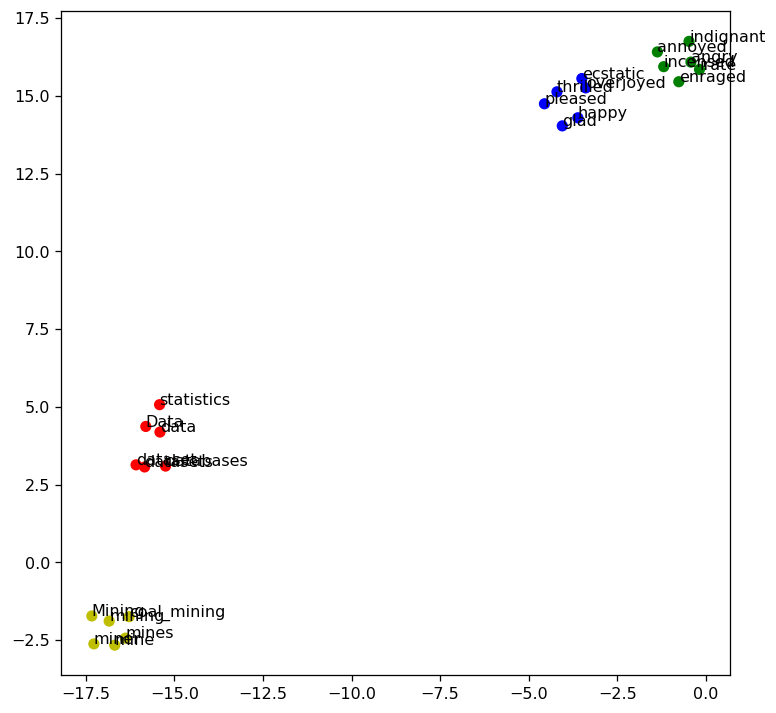

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words) #24
all_word = list(model.index_to_key) # google_model所有文字200
word_train = target_words + all_word[:size] # 24+200
X_train = model[word_train]
print(X_train.shape)

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28) #將維度降到2

## training
X_tsne = tsne.fit_transform(X_train)
print(X_tsne.shape)
## plot the result 顯示僅這24個單字
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [ ]:
# Answer here
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15 #前十五名 , 共60個單字
angry_words = [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
happy_words = [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
sad_words = [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]
fear_words = [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]

print('angry_words: ', angry_words)
print('happy_words: ', happy_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = happy_words + angry_words + sad_words + fear_words #60
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn #利用顏色可視化
print(color)

angry_words:  ['irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
happy_words:  ['glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
sad_words:  ['saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy', '

(60, 300)
(60, 2)


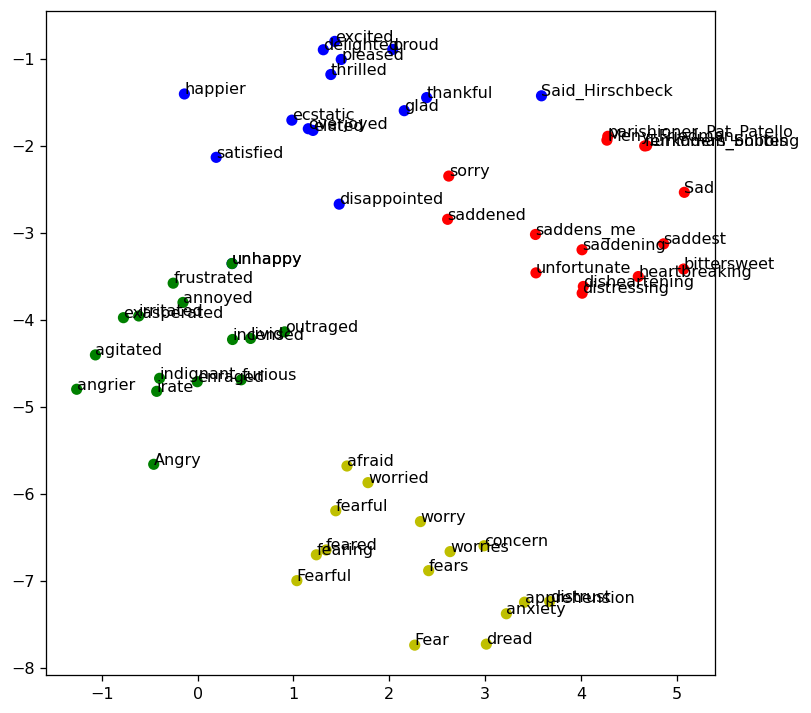

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
# size = 200
target_size = len(target_words) #60
# all_word = list(model.index_to_key) # google_model所有文字200
# word_train = target_words + all_word[:size] # 24+200
word_train = target_words
X_train = model[word_train]
print(X_train.shape)

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28) #將維度降到2

## training
X_tsne = tsne.fit_transform(X_train)
print(X_tsne.shape)
## plot the result 顯示僅這24個單字
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---